In [1]:
import openai
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import time
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import nltk
from nltk.stem.snowball import SnowballStemmer
import re

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

In [37]:
llm_output = pd.read_csv('transcripts/LLM_outputs.csv')
qna_analysis = pd.read_csv('transcripts/LLM_QnA_analysis.csv')

# Add GoEmotions labels to the llm_output
emotions_presentation = pd.read_csv('goemotions/presentation_summary_final.csv', delimiter='|')
emotions_qna = pd.read_csv('goemotions/qna_summary_final.csv', delimiter='|')

llm_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimism', 'pessimism', 'vagueness', 'language_accessibility',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]


In [38]:
qna_analysis = qna_analysis[["call_ID"] + qna_labels]
qna_analysis.drop_duplicates(keep='first', inplace=True)
emotions_presentation = emotions_presentation[["call_ID"] + emotions]
emotions_presentation.drop_duplicates(keep='first', inplace=True)
emotions_qna = emotions_qna[["call_ID"] + emotions]
emotions_qna.drop_duplicates(keep='first', inplace=True)

# add qna_labels to the llm_output
llm_output = pd.merge(llm_output, qna_analysis, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_presentation, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_qna, on='call_ID', how='left')

for emotion in emotions:
    llm_output[emotion] = llm_output[f'{emotion}_x'] + llm_output[f'{emotion}_y']
    llm_output.drop([f'{emotion}_x', f'{emotion}_y'], axis=1, inplace=True)

# transfrom language_accessibility_x and language_accessibility_y to language_accessibility
llm_output['language_accessibility'] = (llm_output['language_accessibility_x'] + llm_output['language_accessibility_y']) / 2
llm_output.drop(['language_accessibility_x', 'language_accessibility_y'], axis=1, inplace=True)

llm_output.head()

,RR,ActIndustryDistress1,ActIndustryDistress2,Senior secured,Senior unsecured,Senior subordinated,Subordinated \& Junior,Equity value,Default barrier,Net income margin,...,gratitude,joy,nervousness,pride,realization,relief,remorse,sadness,surprise,language_accessibility
0,29.023972,0,1,0,1,0,0,635.12600,0.173560,-0.026785,...,0.000000,0.000000,0.0,0.000000,0.437639,0.0,0.0,0.0,0.000000,0.805556
1,8.869420,1,0,0,1,0,0,0.00000,0.000000,0.000000,...,0.090383,0.000000,0.0,0.033282,0.902542,0.0,0.0,0.0,0.268706,0.833333
2,33.210455,0,0,0,1,0,0,228.77559,0.000000,0.000000,...,0.044457,0.173351,0.0,0.000000,0.457140,0.0,0.0,0.0,0.000000,0.777778
3,11.875000,0,0,0,0,1,0,-91.83100,1.053145,-0.375589,...,0.104434,0.000000,0.0,0.000000,0.719042,0.0,0.0,0.0,0.245594,0.861111
4,18.340000,0,0,0,1,0,0,-96.67500,0.679972,-0.060670,...,0.039226,0.093447,0.0,0.000000,0.443096,0.0,0.0,0.0,0.000000,0.694444


In [39]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

In [63]:
'''BOND LEVEL'''
# Select the supporting features, nlp_lables, and RR from final_df
final_df = llm_output[['RR']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + llm_labels 
                    + qna_labels
                    + emotions
                    ]

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df.drop_duplicates()

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     21.85
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          9.20e-115
Time:                        14:37:21   Log-Likelihood:                -4561.9
No. Observations:                1051   AIC:                             9212.
Df Residuals:                    1007   BIC:                             9430.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     58

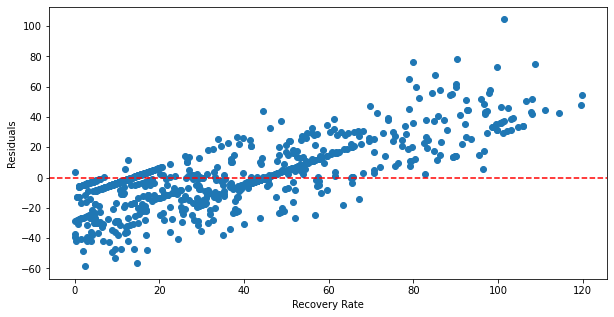

In [64]:
# Bond data 2 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

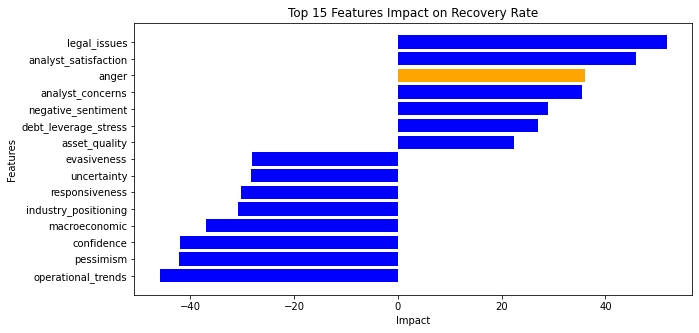

In [66]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

# Sort the importance values based on absolute values, not just positive or negative
top_10_importances = importances.abs().sort_values(ascending=False).head(15)

# reduce importances to only the top 10
importances = importances[top_10_importances.index]
importances = importances.sort_values()

# if features is from supporting_features_1 or supporting_features_2, then color it orange
colors = ['orange' if feature in emotions else 'blue' for feature in importances.index]


plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.barh(importances.index, importances.values, color=colors)
plt.xlabel('Impact')
plt.ylabel('Features')
plt.title('Top 15 Features Impact on Recovery Rate')
plt.show()

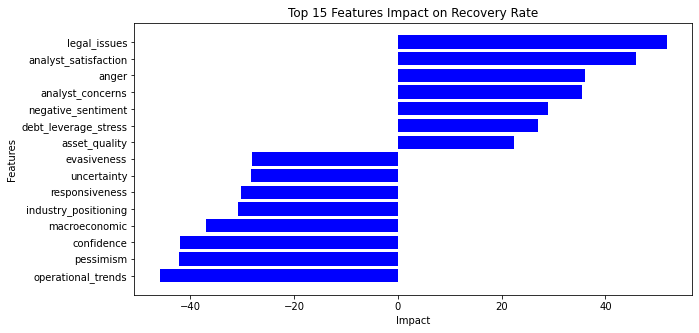

In [65]:
# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

# Sort the importance values based on absolute values, not just positive or negative
top_10_importances = importances.abs().sort_values(ascending=False).head(15)

# reduce importances to only the top 10
importances = importances[top_10_importances.index]
importances = importances.sort_values()

# if features is from supporting_features_1 or supporting_features_2, then color it orange
colors = ['orange' if feature in supporting_features_1 + supporting_features_2 else 'blue' for feature in importances.index]


plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values)
plt.barh(importances.index, importances.values, color=colors)
plt.xlabel('Impact')
plt.ylabel('Features')
plt.title('Top 15 Features Impact on Recovery Rate')
plt.show()